# Procesamiento Datos

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

df_p_forecast = pd.read_csv(r"C:\Users\alanu\Documents\Proyecto_Integrador_GITHUB_28.03.2025\BaseDeDatos\polynomial_forecasts.csv", index_col = 0)
df_p_forecast = df_p_forecast.T.reset_index(drop= True).round()
df_datos = pd.read_csv(r"C:/Users/alanu/Documents/Proyecto_Integrador_GITHUB_28.03.2025/BaseDeDatos/DATOSLIMPIOSRAPPI.csv",encoding='latin-1')
def tipo_tarjetas(df,labels):
    ''' 
    Recibe un data frame de series de tiempo. Determina cuales son decrecientes(ignorando el ruido) y por tanto solo generan stock inicial
    Con esa información regresa un diccionario
    {"nombre" : tipo}
    Donde:
        tipo 1: Tarjeta usual
        tipo 0: Tarjeta de temporda

    '''
    TipoProd = {}
    num = 0
    for col in df.columns:
        aux_series = df[col]
        j = 1
        inicio_pord = 0
        for i in aux_series.isna()[:-1]:
            if i != aux_series.isna()[j] and i :
                inicio_pord = j
                continue
            j+=1
        aux_series = aux_series[inicio_pord:]            
        descomposition = seasonal_decompose(aux_series,period=1)
        trend = descomposition.trend.reset_index(drop= True)
        # plt.figure()
        # plt.plot(trend)
        # plt.show()
        for i in range(len(trend)-1):
            v_i = trend[i]
            v_i1 = trend[i+1]
            if v_i1 > v_i:
                TipoProd[labels[num]] =True
                break
            else:
                TipoProd[labels[num]] =False
        num +=1
    return TipoProd


col_produccion_inicial = []
col_demanda = []
col_material = []
for i in df_datos.columns:
    if "Produccion Inicial" in i:
        col_produccion_inicial.append(i)
    if "Entregas" in i:
        col_demanda.append(i)
    if "Stock" in i:
        col_material.append(i)
df_stock = df_datos[col_produccion_inicial].copy()
df_stock = df_stock.drop(["Produccion Inicial Total"],axis= 1)
df_demanda = df_datos[col_demanda].copy()
df_material = df_datos[col_material].copy()

In [2]:
filtro_nan = []
for i in df_stock.columns:
    if df_stock[i].isna().sum() <=18:
        filtro_nan.append(True)
    else:
        filtro_nan.append(False)
df_entregas = df_stock.T[filtro_nan].T
df_entregas = df_entregas.T.sort_index().T

In [3]:
tarjetas = [i[19:]for i in df_stock.columns]
dict_tipo_tarjeta = tipo_tarjetas(df_stock,tarjetas)
Ultimo_stock = df_entregas.loc[25]
tarjetas_con_restock = [dict_tipo_tarjeta[i[19:]] for i in Ultimo_stock.index]
tarjeta_inicial =Ultimo_stock[tarjetas_con_restock]
df_p_forecast = df_p_forecast.iloc[:,:-7]

In [4]:
cols = df_p_forecast.columns
for col in cols:
    df_p_forecast = df_p_forecast.rename(columns={col:col.replace("_"," ")[15:].title()})
df_p_forecast = df_p_forecast.rename(columns={'Cardtrinas':'Cardtrina',"Minion Rayo":"Minon Rayo"})
# df_p_forecast = df_p_forecast.drop(columns=["Playcard"])

In [5]:
tarjetas_con_restock = [dict_tipo_tarjeta[col] for col in df_p_forecast.columns]

In [6]:
df_p_forecast = df_p_forecast.T[tarjetas_con_restock].T

In [7]:

df = df_p_forecast.copy()

# Número de semanas por mes (puedes ajustarlo)
semanas_por_mes = 4  # usa 4.33 si quieres precisión exacta

# Lista para guardar las nuevas filas
filas_semanales = []

for i, row in df.iterrows():
    for semana in range(semanas_por_mes):
        nueva_fila = row.copy()
        nueva_fila['month_index'] = i
        nueva_fila['week_index'] = semana + 1 + semanas_por_mes * i
        nueva_fila = nueva_fila / semanas_por_mes  # divide demanda mensual
        filas_semanales.append(nueva_fila)

# Convertir a DataFrame
df_weekly = pd.DataFrame(filas_semanales)

df_weekly_forecast = df_weekly.round()
df_weekly_forecast = df_weekly_forecast.reset_index(drop=True)
df_weekly_forecast = df_weekly_forecast.drop(columns=["month_index","week_index"])
df_weekly_forecast = df_weekly_forecast.T.sort_index().T

#Nuevas tarjetas son a partir del 13
#Playcard, Ocean plastic
# tarjeta_inicial = tarjeta_inicial.drop(["Produccion Inicial Wicked"]) #"Produccion Inicial Cincita Reemplazo",
cols_nuevas_tarjetas = ["Produccion Inicial Ocean Plastic","Produccion Inicial Playcard"]
cols_viejas_tarjetas = list(set(tarjeta_inicial.index) - set(cols_nuevas_tarjetas))
#Df
df_weekly_forecast = df_weekly_forecast.drop(["Cardlaveritas 2024"],axis=1)
tarjeta_inicial = tarjeta_inicial.drop("Produccion Inicial Cincita Reemplazo")
new_index = [i[19:] for i in tarjeta_inicial.index]
tarjeta_inicial= pd.Series(tarjeta_inicial.values,index=new_index)

# Planteamiento


Primero tenemos una tupla de estados en el momento k.

$x(k) = {g(\vec{i_k})}$

- $\vec{i}$: Inventario de tarjetas y materiales
- $\vec{g}$: Número de kits disponibles basados en el inventario. Estos estan compuestos por 1 bolsa TC, 1 sticker de seguridad, 1 tarjeta de crédito y 1 flyer germinable(con OceanPlastic y Nuevos lanzamientos solamente)

Para representar la cantidad de kits disponibles en el momento k se planteo

$g(\vec{i_k}) = \min(i_b^k,i_s^k,i_{t_n}^k,i_f^k)$

Tanto $\vec{i},\vec{g} >0$ 

En cuanto a la variable de control en el momento k, son los materiales y o procesos pedidos que pido para tener disponible mas adelante con delat d.

$u(k,d) = \vec{p^{k+d}}$

En cuanto a la evolución del sistema
- $\vec{p}$: El pedido de materiales
- $\vec{d}$: El delay del pedido

Donde para poder hacer una acción la

$\sum_{i=0, i \epsilon Tarjetas}^{n} p_i^{k+d_i} > 5000$


Se dividirá en semanas pues es como se maneja el problema.
En cuanto a la demanda se asumirá el forecast como si fuera algo determinado.
La evolución del sistema se verá de la siguiente forma:

$x(k+1) = f(x(k),u(k),k) = g(\vec{i_{k+1}})$

Donde $f(x(k),u(k),k)$ representa la evolucón del sistema


$f(x(k),u(k),k) = g_k -d_k + \sum^k_{j=0 ,t_o+j=k}  p_i^{t_o+j}$


Donde $\sum^k_{j=0 ,t_o+j=k}  p_i^{t_o+j}$ son las repercuciones de las acciones pasadas

En cuando a mi funcional, que se plantea de la siguiente forma:

$J = F[x(k),u(k),k] + S[N]$


Para este caso, donde se busca maximizar utilidades lo planteo como

$F[x(k),u(k),k] = \vec{\alpha}\vec{g} - \vec{\gamma}|\vec{p}|$

$S[N] = 0$

Es decir la ganancia de producir los diferentes kits menos el costo de mandarlos a producir.

Al mismo tiempo, se establecerá un stock de seguridad de insumos para los diferentes materiales y se planteará como una restricción.

$\vec{i} > \vec{r}$
 - r: es el vector de restricciones

 ME FALTA PONER QUE PARA HACER INVENTARIO DE TARJETAS OCUPO HACER CARDBODY Y LUEGO UN PERSONALIZACION EN MI PLANTAMIENTO

## Funciones

In [ ]:
#Por inventario( tarjeta, materiales)
df_ej_pedidos = pd.DataFrame([["Stocks Cardbody Black",0,3,100],["Stocks Cardbody Black",0,3,100],["Stocks Stickers",0,4,100],["Stocks Bolsas",0,4,100]],columns= ["Mat","t0","Delay","Val"])

# Por tarjeta
df_ej_procesos = pd.DataFrame( [["Black",0,100],["Black",0,100],["Playcard",1,100]] ,columns=["Tarjeta","t0","Val"])

In [9]:
#Estados iniciales y declaracion de tablas para el registro historico del proceso
t_cardbody = 8
t_personalizacion = 2
t_bolsa = 8
t_stickers = 4
t_flyer = 6
t_kit = 5
material_inicial = df_material.drop(columns=["Stocks Tarjetas Personalizadas"]).loc[25]
s0 = pd.concat([tarjeta_inicial,material_inicial])



df_estado =  pd.DataFrame([s0.values],columns=s0.index)
df_pedido_mat = pd.DataFrame(columns= ["Mat","t0","Delay","Val"])
df_proceso_tar = pd.DataFrame(columns=["Tarjeta","t0","Val"])
index_tarjetas = 9
str_tarjetas = tarjeta_inicial.index
str_materiales = material_inicial.index
# Esto es como el total de g_s posibles
def agregar_tipo(s_forecast):
    indice = s_forecast.index
    tipo = [0]*len(indice)
    for num,i in enumerate(indice):
        if i in ['Ocean Plastic', 'Playcard']:
            tipo[num] = 0
        elif i in ['Stocks Cardbody Black','Stocks Flyer Germinable', 'Stocks Bolsas', 'Stocks Stickers']:
            tipo[num] = 2
        else:
            tipo[num] = 1
    df = pd.DataFrame(s_forecast.values, index = s_forecast.index,columns=["Vals"])
    df["Tipo"] = tipo
    return df
def func_g(inventario,tarjetas):
    ''' 
    1: Tarjetas Nuevas
    0: Tarjetas Viejas
    '''
    tarjetas = agregar_tipo(tarjetas)
    filtro = tarjetas["Tipo"] == 1
    tarjetas_nuevas= tarjetas[filtro]["Vals"]
    tarjetas_viejas= tarjetas[np.invert(filtro)]["Vals"]
    tarjetas = tarjetas.drop("Tipo",axis=1)
    lista_para_nuevas = inventario.loc[['Stocks Cardbody Black', 'Stocks Flyer Germinable', 'Stocks Bolsas','Stocks Stickers']]
    lista_para_viejas = inventario.loc[['Stocks Cardbody Black', 'Stocks Bolsas','Stocks Stickers']]

    for t, lista,f in zip([tarjetas_nuevas,tarjetas_viejas],[lista_para_nuevas,lista_para_viejas],[filtro,np.invert(filtro)]):
        df = pd.DataFrame(t)
        for i,col in zip(lista,lista.index):
            df[col]=i
        tarjetas[f]["Vals"] = np.array(df.T.min().values)
    tarjetas = tarjetas.rename({"Vals":"kits"},axis=1)
    return tarjetas
def func_g_max(inventario,tipo = 0):
    if tipo == 1:
        lista = inventario.loc[['Stocks Cardbody Black', 'Stocks Flyer Germinable', 'Stocks Bolsas','Stocks Stickers']]
    else:
        lista = inventario.loc[['Stocks Cardbody Black', 'Stocks Bolsas','Stocks Stickers']]    
    return min(lista)
def func_J(g,cantidad_pedidos,cantidad_procesos,alpha = 10,gamma =1,theta = 1):
    return alpha*np.sum(g) - gamma*cantidad_pedidos -theta*cantidad_procesos 

#Nuevas Tarjetas
def u_tarjeta(df_procesos,k,tarjetas):
    filtro_tiempo_proceso =  df_procesos["t0"] + t_personalizacion ==k
    procesos = df_procesos[filtro_tiempo_proceso]
    aux = procesos.groupby(by = "Tarjeta")["Val"].sum()  
    return  aux.reindex(tarjetas)    


def gasto_material_demanda_general(df_demanda_tarjetas):
    gasto_de_mat = df_demanda_tarjetas.groupby(by ="Tipo")["Val"].sum()
    return gasto_de_mat
def gasto_material_demanda_tarjetas(df_demanda_tarjetas):
    # filtro_solo_tarjetas = df_demanda_tarjetas["Tipo"] !=2
    gasto_tarjetas = df_demanda_tarjetas.groupby(by ="Mat")["Val"].sum()
    return gasto_tarjetas

# Perdida de tarjetas
def u_material_stock(df_pedidos,k,materiales):
    ''' 
    Recibe solo las tarjetas pediddas, no todo el material
    '''
    filtro_tiempo_pedido = df_pedidos["t0"] +df_pedidos["Delay"] ==k
    pedidos = df_pedidos[filtro_tiempo_pedido].groupby(by = "Mat")["Val"].sum()
    return pedidos.reindex(materiales)
def evol_inventarios(k,df_weekly_forecast,sn,df_pedidos,df_proceso,index_tarjetas = 9):
#               Actualizacion de tarjetas nuevas
    ultimo_material = sn[index_tarjetas:]
    tarjetas_enkits_demanda =func_g(ultimo_material,df_weekly_forecast.loc[k])
    tn = sn[:index_tarjetas] - tarjetas_enkits_demanda["kits"] + u_tarjeta(df_proceso,k,str_tarjetas).fillna(0)# -df_weekly_forecast.loc[0].values
    tn[tn<0] =0
    tn = tn.fillna(0)
    #                 Actualizacion de material
    # Material usado
    kits_usados_tarjeta = agregar_tipo(tarjetas_enkits_demanda)
    kits_usados_tipo = kits_usados_tarjeta.groupby("Tipo").sum()
    vals = [0]*4
    for num,i in enumerate(str_materiales):
        if i == 'Stocks Flyer Germinable':
            vals[num] = kits_usados_tipo.sum().values[0]
        elif i == 'Stocks Cardbody Black':
            vals[num] = int(u_tarjeta(df_proceso,k,str_tarjetas).fillna(0).sum())
        else:
            vals[num] = kits_usados_tipo.loc[0].values[0]
    s_material_usado = pd.Series(vals,index= material_inicial.index)# 
    mn = sn[index_tarjetas:]-s_material_usado + u_material_stock(df_pedidos,0,str_materiales).fillna(0)
    mn[mn<0] =0
    mn = mn.fillna(0)
    estado = pd.concat([tn,mn])

    kits = func_g(mn,df_weekly_forecast.loc[k+1])
    cantidad_pedidos = len(df_pedidos["t0"].value_counts())
    cantidad_procesos = len(df_proceso["t0"].value_counts())
    funcional = func_J(kits,cantidad_pedidos,cantidad_procesos)

    return estado,funcional
#Acciones
def generar_posibles_pedidos(k,lista, cond = False):
    # Podrías probar 3-5 cantidades diferentes para cada tipo de material
    opciones = []
    fun = lambda a: 2000 if a < 20000 else (10000 if a < 100000 else 15000)
    l = [np.arange(0,val,fun(val)) for val in lista]
    combinatoria = list(product(*l)) 
    for c in combinatoria:
        pedidos = pd.DataFrame({
            "Mat": str_materiales,
            "t0": [k]*len(str_materiales),
            "Delay": [t_cardbody,t_flyer,t_bolsa,t_stickers],  # entrega al siguiente paso
            "Val": c
        })
        opciones.append(pedidos)
    return opciones

def generar_posibles_procesos(k,l_max):
    opciones = []
    fun = lambda a: 20 if a < 100 else (200 if a < 1000 else 1000)
    l = [np.arange(0,max,fun(max)) for max in l_max*3]
    combinatoria = list(product(*l)) 
    for c in combinatoria:
        procesos = pd.DataFrame({
            "Tarjeta": str_tarjetas,
            "t0": [k]*len(str_tarjetas),
            "Val": c
        })
        opciones.append(procesos)
    return opciones



def generar_posibles_pedidos_sample(k, lista, n_samples=30):
    opciones = []
    for _ in range(n_samples):
        val = [np.random.randint(0, v+1) for v in lista]
        pedidos = pd.DataFrame({
            "Mat": str_materiales,
            "t0": [k]*len(str_materiales),
            "Delay": [t_cardbody, t_flyer, t_bolsa, t_stickers],
            "Val": val
        })
        opciones.append(pedidos)
    return opciones

def generar_posibles_procesos_sample(k,l_max,n_samples = 30):
    opciones = []
    for _ in range(n_samples):
        val = [np.random.randint(0, v+1) for v in l_max]
        procesos = pd.DataFrame({
            "Tarjeta": str_tarjetas,
            "t0": [k]*len(str_tarjetas),
            "Val": val
        })
        opciones.append(procesos)
    return opciones





## Codigo Greedy Mensual

In [10]:
df_p_forecast = df_p_forecast.T.sort_index().T

In [18]:
df_month_forecast = df_p_forecast[df_weekly_forecast.columns]
warnings.filterwarnings("ignore")


In [ ]:
warnings.filterwarnings("ignore")
K = len(df_month_forecast)  # número total de pasos
limite_materiales = df_material.mean() + 2*df_material.std()
limite_materiales = limite_materiales[1:]
limite_tarjetas = df_month_forecast.max()
estado_actual = s0
historial_estados = [estado_actual]
historial_funcional = []
df_mejor_pedidos = pd.DataFrame()
df_mejor_procesos = pd.DataFrame()

t_cardbody = 2
t_personalizacion = math.ceil(2/4) 
t_bolsa = 2
t_stickers = 1
t_flyer = math.ceil(6/4)
t_kit = math.ceil(5)

# Codigo con sampleo markoviano + Greedy. Termina de correr que ya es algo
for k in range(K-1):
    mejor_J = np.inf
    mejor_pedidos = pd.DataFrame(columns= ["Mat","t0","Delay","Val"])
    mejor_procesos = pd.DataFrame(columns= ["Tarjeta","t0","Val"])
    
    for posibles_pedidos in generar_posibles_pedidos_sample(k,limite_materiales,10): #generar_posibles_pedidos(k,limite_materiales)
        for posibles_procesos in generar_posibles_procesos_sample(k,limite_tarjetas,10):
            estado, J = evol_inventarios(k, df_month_forecast, estado_actual, posibles_pedidos, posibles_procesos)

            # Restringe a que haya al menos 5000 tarjetas
            try:
                aux = mejor_J.values
            except:
                aux = mejor_J
            if estado[:index_tarjetas].sum() >= 5000 and J.values <aux:
                mejor_J = J
                mejor_pedidos = posibles_pedidos
                mejor_procesos = posibles_procesos
    
    # Aplica la mejor acción
    estado_actual, J = evol_inventarios(k, df_month_forecast, estado_actual, mejor_pedidos, mejor_procesos)
    historial_estados.append(estado_actual)
    historial_funcional.append(J)
    
    # Acumular df_pedidos y df_procesos totales
    df_mejor_pedidos = pd.concat([df_mejor_pedidos, mejor_pedidos])
    df_mejor_procesos = pd.concat([df_mejor_procesos, mejor_procesos])

KeyboardInterrupt: 

## Codigo Euristico + Greedy Mensual

In [73]:
def heuristica_pedido(k,df_forecast,inventario,n=2):
    # Falta de material en 3 meses
    # No toma en cuenta los diferentes meses}
    #Quiero que me de un out put de lso 4 materiales
    val = 0
    for i in range(k,k+n):
        try:
            val = val +df_forecast.loc[i]
        except:
            val += val
    kits_por_usar = agregar_tipo(func_g(inventario,val)).groupby(by = "Tipo").sum()
    fun = lambda a: a[0] 
    
    max_por_material = {
        'Stocks Cardbody Black': (max(fun(kits_por_usar.loc[1] - inventario[0]),0)),
        'Stocks Flyer Germinable': (max(fun(kits_por_usar.loc[0]-inventario[1]),0)),
        'Stocks Bolsas': (max(fun(kits_por_usar.loc[1]-inventario[2]),0)),
        'Stocks Stickers': (max(fun(kits_por_usar.loc[1]-inventario[3]),0)),
    }
    return pd.Series(max_por_material)

#Combinatoria, que descarte las mamadas.Osea que si una combinacion ni si quiera cubre las demandas del siguiente. La evito
def generar_posibles_pedidos_heuristico(k, df_forecast,inventario,n_samples=30):
    fun = lambda a: 10 if a < 100 else (100 if a < 1000 else 1000)
    l_max = heuristica_pedido(k,df_forecast,inventario)
    reglas_por_material = {
        'Stocks Cardbody Black': (0, l_max[0], fun(l_max[0])),
        'Stocks Flyer Germinable': (0, l_max[1], fun(l_max[1])),
        'Stocks Bolsas': (0, l_max[2], fun(l_max[2])),
        'Stocks Stickers': (0, l_max[3], fun(l_max[3])),
    }

    materiales = list(reglas_por_material.keys())
    opciones = []

    for _ in range(n_samples):
        vals = []
        for mat in materiales:
            low, high, step = reglas_por_material[mat]
            posibles = np.arange(low, high+1, step)
            val = int(np.random.choice(posibles))
            vals.append(val)

        pedidos = pd.DataFrame({
            "Mat": materiales,
            "t0": [k]*len(materiales),
            "Delay": [t_cardbody, t_flyer, t_bolsa, t_stickers],
            "Val": vals
        })
        opciones.append(pedidos)
    return opciones

def heuristica_procesos(k,df_forecast,inventario,tarjetas,n=2):
    # Falta de material en 3 meses
    # No toma en cuenta los diferentes meses}
    #Quiero que me de un out put de lso 4 materiales
    val = 0
    for i in range(k,k+n):
        try:
            val = val +df_forecast.loc[i]
        except:
            val += val
    kits_por_usar = func_g(inventario,val)
    # fun = lambda a: a[0]   
    print(max(kits_por_usar["kits"][1]-tarjetas[1],0)) #max(kits_por_usar[1] - tarjeta[1],0)
    max_por_tarjeta = {
        tarjeta: (max(kits_por_usar["kits"][num]-tarjetas[num],0)) for num,tarjeta in enumerate(str_tarjetas)
    }
    return pd.Series(max_por_tarjeta)
def generar_posibles_procesos_heuristico(k, df_forecast,inventario,tarjetas,n_samples=30):
    fun = lambda a: 10 if a < 100 else (100 if a < 1000 else 1000)
    l_max = heuristica_procesos(k,df_forecast,inventario,tarjetas)
    reglas_por_tarjeta = {
        tarjeta: (0, l_max[num], fun(l_max[num])) for num,tarjeta in enumerate(str_tarjetas)
    }

    materiales = list(reglas_por_tarjeta.keys())
    opciones = []

    for _ in range(n_samples):
        vals = []
        for mat in materiales:
            low, high, step = reglas_por_tarjeta[mat]
            posibles = np.arange(low, high+1, step)
            val = int(np.random.choice(posibles))
            vals.append(val)

        procesos = pd.DataFrame({
            "Tarjeta": str_tarjetas,
            "t0": [k]*len(str_tarjetas),
            "Val": vals
        })
        opciones.append(procesos)
    return opciones

In [ ]:
K = len(df_month_forecast)  # número total de pasos
limite_materiales = df_material.mean() + 2*df_material.std()
limite_materiales = limite_materiales[1:]
limite_tarjetas = df_month_forecast.max()
estado_actual = s0
historial_estados = [estado_actual]
historial_funcional = []
df_mejor_pedidos = pd.DataFrame()
df_mejor_procesos = pd.DataFrame()

t_cardbody = 2
t_personalizacion = math.ceil(2/4) 
t_bolsa = 2
t_stickers = 1
t_flyer = math.ceil(6/4)
t_kit = math.ceil(5)
 
# Codigo con sampleo markoviano + Greedy. Termina de correr que ya es algo
for k in range(K-1):
    mejor_J = np.inf
    mejor_pedidos = pd.DataFrame(columns= ["Mat","t0","Delay","Val"])
    mejor_procesos = pd.DataFrame(columns= ["Tarjeta","t0","Val"])
    
    for posibles_pedidos in generar_posibles_pedidos_heuristico(k,df_p_forecast,es): #generar_posibles_pedidos(k,limite_materiales)
        for posibles_procesos in generar_posibles_procesos(k,limite_tarjetas):
            estado, J = evol_inventarios(k, df_month_forecast, estado_actual, posibles_pedidos, posibles_procesos)

            # Restringe a que haya al menos 5000 tarjetas
            try:
                aux = mejor_J.values
            except:
                aux = mejor_J
            if estado[:index_tarjetas].sum() >= 5000 and J.values <aux:
                mejor_J = J
                mejor_pedidos = posibles_pedidos
                mejor_procesos = posibles_procesos
    
    # Aplica la mejor acción
    estado_actual, J = evol_inventarios(k, df_month_forecast, estado_actual, mejor_pedidos, mejor_procesos)
    historial_estados.append(estado_actual)
    historial_funcional.append(J)
    
    # Acumular df_pedidos y df_procesos totales
    df_mejor_pedidos = pd.concat([df_mejor_pedidos, mejor_pedidos])
    df_mejor_procesos = pd.concat([df_mejor_procesos, mejor_procesos])

SyntaxError: invalid syntax (3810663005.py, line 24)

## Codigo Sampleo Markoviano + Greedy Semanal

In [ ]:
warnings.filterwarnings("ignore")
K = len(df_weekly_forecast)  # número total de pasos
limite_materiales = df_material.mean() + 2*df_material.std()
limite_materiales = limite_materiales[1:]
limite_tarjetas = df_weekly_forecast.max()
estado_actual = s0
historial_estados = [estado_actual]
historial_funcional = []
df_mejor_pedidos = pd.DataFrame()
df_mejor_procesos = pd.DataFrame()
t_cardbody = 8
t_personalizacion = 2
t_bolsa = 8
t_stickers = 4
t_flyer = 6
t_kit = 5


# Codigo con sampleo markoviano + Greedy. Termina de correr que ya es algo
for k in range(K-1):
    mejor_J = np.inf
    mejor_pedidos = pd.DataFrame(columns= ["Mat","t0","Delay","Val"])
    mejor_procesos = pd.DataFrame(columns= ["Tarjeta","t0","Val"])
    
    for posibles_pedidos in generar_posibles_pedidos_sample(k,limite_materiales,10): #generar_posibles_pedidos(k,limite_materiales)
        for posibles_procesos in generar_posibles_procesos_sample(k,limite_tarjetas,10):
            estado, J = evol_inventarios(k, df_weekly_forecast, estado_actual, posibles_pedidos, posibles_procesos)

            # Restringe a que haya al menos 5000 tarjetas
            try:
                aux = mejor_J.values
            except:
                aux = mejor_J
            if estado[:index_tarjetas].sum() >= 5000 and J.values <aux:
                mejor_J = J
                mejor_pedidos = posibles_pedidos
                mejor_procesos = posibles_procesos
    
    # Aplica la mejor acción
    estado_actual, J = evol_inventarios(k, df_weekly_forecast, estado_actual, mejor_pedidos, mejor_procesos)
    historial_estados.append(estado_actual)
    historial_funcional.append(J)
    
    # Acumular df_pedidos y df_procesos totales
    df_mejor_pedidos = pd.concat([df_mejor_pedidos, mejor_pedidos])
    df_mejor_procesos = pd.concat([df_mejor_procesos, mejor_procesos])


## Codigo greddy(no termina de correr nunca) semanal

In [ ]:
warnings.filterwarnings("ignore")
K = len(df_weekly_forecast)  # número total de pasos
limite_materiales = df_material.mean() + 2*df_material.std()
limite_materiales = limite_materiales[1:]
limite_tarjetas = df_weekly_forecast.max()
estado_actual = s0
historial_estados = [estado_actual]
historial_funcional = []
df_mejor_pedidos = pd.DataFrame()
df_mejor_procesos = pd.DataFrame()



# Codigo con sampleo markoviano + Greedy. Termina de correr que ya es algo
for k in range(K-1):
    mejor_J = np.inf
    mejor_pedidos = pd.DataFrame(columns= ["Mat","t0","Delay","Val"])
    mejor_procesos = pd.DataFrame(columns= ["Tarjeta","t0","Val"])
    
    for posibles_pedidos in generar_posibles_pedidos(k,limite_materiales): #generar_posibles_pedidos(k,limite_materiales)
        for posibles_procesos in generar_posibles_procesos(k,limite_tarjetas):
            estado, J = evol_inventarios(k, df_weekly_forecast, estado_actual, posibles_pedidos, posibles_procesos)

            # Restringe a que haya al menos 5000 tarjetas
            try:
                aux = mejor_J.values
            except:
                aux = mejor_J
            if estado[:index_tarjetas].sum() >= 5000 and J.values <aux:
                mejor_J = J
                mejor_pedidos = posibles_pedidos
                mejor_procesos = posibles_procesos
    
    # Aplica la mejor acción
    estado_actual, J = evol_inventarios(k, df_weekly_forecast, estado_actual, mejor_pedidos, mejor_procesos)
    historial_estados.append(estado_actual)
    historial_funcional.append(J)
    
    # Acumular df_pedidos y df_procesos totales
    df_mejor_pedidos = pd.concat([df_mejor_pedidos, mejor_pedidos])
    df_mejor_procesos = pd.concat([df_mejor_procesos, mejor_procesos])

24

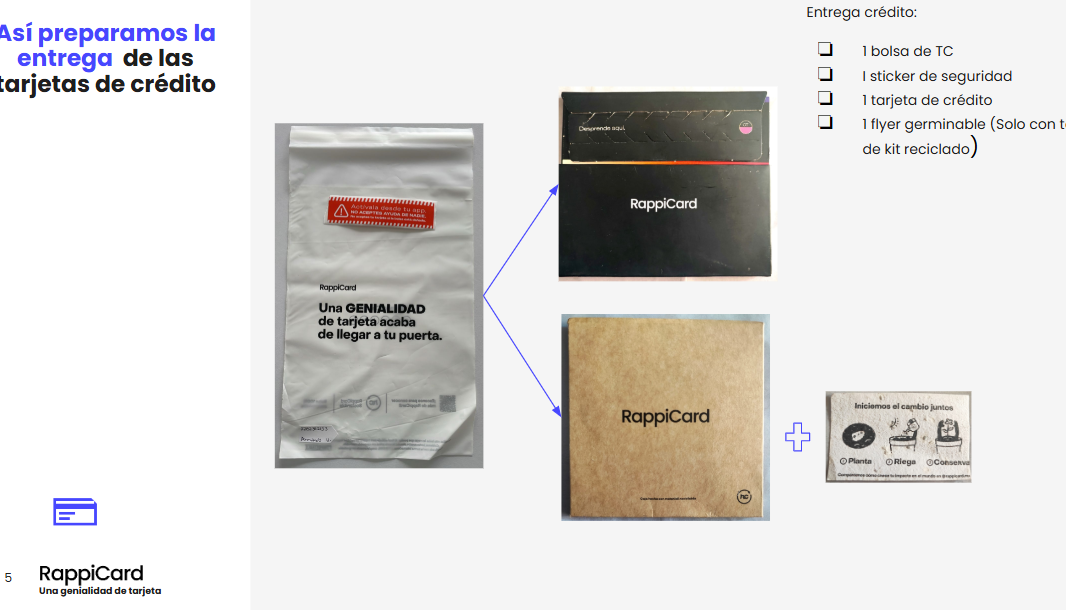

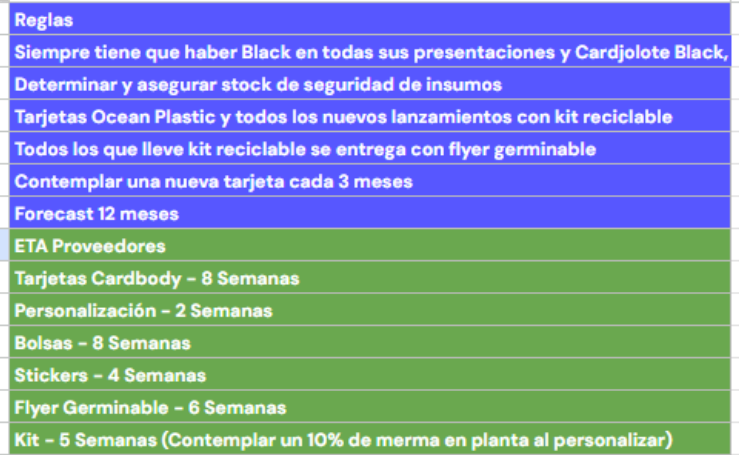

In [ ]:
# from functools import lru_cache

# # Demanda por mes
# demanda = [10, 15, 12, 18]
# horizonte = len(demanda)

# # Supongamos que tenemos 5 productos en inventario al principio
# stock_inicial = 5

# @lru_cache(maxsize=None)
# def dp(mes, inventario):
#     if mes == horizonte:
#         return 0  # no hay más demanda

#     mejor = float('-inf')

#     # Probar todas las cantidades que podrías entregar, limitado por inventario + producción
#     for produccion in range(0, 11):  # producir de 0 a 10
#         disponible = inventario + produccion
#         entregar = min(demanda[mes], disponible)

#         nuevo_inv = disponible - entregar
#         valor_futuro = dp(mes + 1, nuevo_inv)

#         utilidad_total = entregar + valor_futuro
#         mejor = max(mejor, utilidad_total)

#     return mejor

# resultado = dp(0, stock_inicial)
# print("Demanda cubierta máxima:", resultado)
